## Train Feature Extractor

Here, we will train a model to classify cars, this is not SOTA training, so no agressive augumentations are used. This will be binary classification(cars and non-cars), I am using stanford cars dataset for cars and coco's val2017 set as non-cars dataset. From both 4000 images will be picked for trianing/validation. It will try to overfit the cars dataset so we can extract features based on them.
* Prepare Dataset
* Train model
* Fine tune model

## Download dataset

In [ ]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# !wget http://images.cocodataset.org/zips/val2017.zip

# # copy to drive to save time 

# !cp /content/cars_train.tgz /content/drive/MyDrive/Datasets
# !cp /content/val2017.zip /content/drive/MyDrive/Datasets

In [ ]:
# copy data from drive

!cp /content/drive/MyDrive/Datasets/cars_train.tgz /content/
!cp /content/drive/MyDrive/Datasets/val2017.zip /content/

In [ ]:
!tar -xzf /content/cars_train.tgz
!unzip -qq /content/val2017.zip

In [ ]:
import torch, torchvision
import os, cv2, random
import numpy as np
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

seed = 42
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [ ]:
print(torch.cuda.get_device_name(0)) 

Tesla T4


In [ ]:
# non cars dir

NON_CARS_DIR = '/content/val2017/' # val coco
non_cars_paths = [NON_CARS_DIR+c for c in os.listdir(NON_CARS_DIR)[:4500]]
len(non_cars_paths)

4500

In [ ]:
# cars dir

CARS_DIR = '/content/cars_train/' # stanford cars
cars_paths = [CARS_DIR+c for c in os.listdir(CARS_DIR)[:4500]]
len(cars_paths)

4500

## Show Data

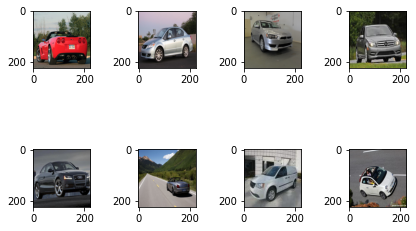

In [ ]:
# cars

r,c = 2,4
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    img = Image.open(cars_paths[a])
    img = img.resize((224, 224))
    axs[i,j].imshow(img)
    a+=1

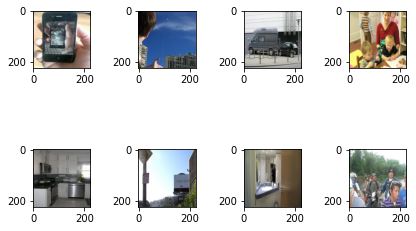

In [ ]:
# non cars

r,c = 2,4
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    img = Image.open(non_cars_paths[a])
    img = img.resize((224, 224))
    axs[i,j].imshow(img)
    a+=1

## Prepare Dataset

In [ ]:
class CarsNonCarsDataset(Dataset):

  def __init__(self, image_paths, labels, transform=None):
    self.transform = transform
    self.image_paths = image_paths
    self.labels = labels
    self.len = len(image_paths)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image/=255
    # image = cv2.resize(image, (224, 224)) # unfreeze for computing data mean/std
    
    label = torch.tensor(self.labels[index], dtype=torch.int64)
    if self.transform:
        image = self.transform(image)
    return image, label

In [ ]:
# make labels, split dataset

total_paths = cars_paths + non_cars_paths
labels = np.zeros([len(total_paths)])
labels[4500:] = 1
x_train, x_test, y_train, y_test = train_test_split(total_paths, labels, test_size=0.2, random_state=seed)

In [ ]:
# compute std and mean for dataset

transform = transforms.Compose([transforms.ToTensor()])

dataset = CarsNonCarsDataset(total_paths, labels, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,  
                                           shuffle=False)
mean = 0.
std = 0.
nb_samples = 0.
for data in dataloader:
    batch_samples = data[0].size(0)
    data[0] = data[0].view(batch_samples, data[0].size(1), -1)
    data[0] = data[0].float()
    mean += data[0].mean(2).sum(0)
    std += data[0].std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean)
print(std)

tensor([0.4692, 0.4519, 0.4299])
tensor([0.2516, 0.2486, 0.2529])


In [ ]:
# prepare dataset, dataloader

BATCH_SIZE = 128
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.Normalize(mean, std)])

transform_val = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.Normalize(mean, std)])

train_dataset = CarsNonCarsDataset(x_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = CarsNonCarsDataset(x_test, y_test, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 7200 and Test Dataset 1800


In [ ]:
train_dataset[6][0].size() # check image size

torch.Size([3, 224, 224])

## Prepare model

In [ ]:
class ResnetCarClassifier(torch.nn.Module):
    
    def __init__(self):
        super(ResnetCarClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=2)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        y = self.sigmoid(x)
        return y

In [ ]:
# check model output

model = ResnetCarClassifier()
img, label = train_dataset[0]
with torch.no_grad():
  output = model(img.reshape(1, 3, 224, 224))
print(output)  

tensor([[0.6372, 0.5055]])


## Training

In [ ]:
# training

def train_model(model, EPOCHS, optimizer, scheduler, BATCH_SIZE, train_loader, val_loader):

  TRAIN_LOSS = []
  VAL_LOSS = []
  VAL_ACC = []
  MIN_LOSS = 20.0
  model_save_path = '/content/resnet_carclassifer.bin'

  cost_function = torch.nn.BCELoss() # BCE loss for binary labels
  onehot = torch.eye(2, device='cuda') # onehot labels

  TRAIN_STEP = len(train_loader)/BATCH_SIZE # to calculate loss
  VALID_STEP = len(val_loader)/BATCH_SIZE

  for epoch in range(1, EPOCHS+1):
    print("Epoch", epoch)
    running_loss = 0.0
    model.train()
    for (x, y) in train_loader:
      optimizer.zero_grad()
      x, y = x.cuda(0), y.cuda(0)
      z = model(x)
      loss = cost_function(z, onehot[y])
      running_loss+=loss.detach()
      loss.backward()
      optimizer.step()

    train_l = running_loss/TRAIN_STEP
    TRAIN_LOSS.append(train_l.item())
    total = 0
    correct = 0 
    print("Training Loss:", train_l.item())
    running_loss = 0.0
    model.eval()

    for (x,y) in val_loader:
      x, y = x.cuda(0), y.cuda(0)
      with torch.no_grad():
        z = model(x)
      loss = cost_function(z, onehot[y])
      running_loss+=loss.detach()
      _, yhat = torch.max(z,1)
      total += y.size(0)
      correct += (yhat == y).sum().item()

    valid_l = running_loss/VALID_STEP
    valid_a = 100 * correct / total
    print("Val Loss:", valid_l.item()) # current step size 78
    VAL_LOSS.append(valid_l.item())
    print('Val Accuracy: %d %%' % valid_a)
    VAL_ACC.append(valid_a)

    if scheduler is not None:
      scheduler.step()
      
    if MIN_LOSS > min(VAL_LOSS):
      MIN_LOSS = min(VAL_LOSS)
      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, model_save_path)
      print('Model Saved...')
  return VAL_LOSS, TRAIN_LOSS, VAL_ACC  

In [ ]:
LR = 0.0001
EPOCHS = 5

model = ResnetCarClassifier().cuda(0)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=0.00001, last_epoch=-1)

val_loss, train_loss, val_acc1 = train_model(model, EPOCHS, optimizer, scheduler, 
                                            BATCH_SIZE, train_loader, val_loader)


Epoch 1
Training Loss: 9.897743225097656
Val Loss: 3.330840587615967
Val Accuracy: 99 %
Model Saved...
Epoch 2
Training Loss: 2.358989953994751
Val Loss: 2.5631630420684814
Val Accuracy: 99 %
Model Saved...
Epoch 3
Training Loss: 0.8232879042625427
Val Loss: 2.7581875324249268
Val Accuracy: 99 %
Epoch 4
Training Loss: 0.6550105810165405
Val Loss: 5.022334098815918
Val Accuracy: 98 %
Epoch 5
Training Loss: 0.3747989535331726
Val Loss: 3.312455415725708
Val Accuracy: 99 %


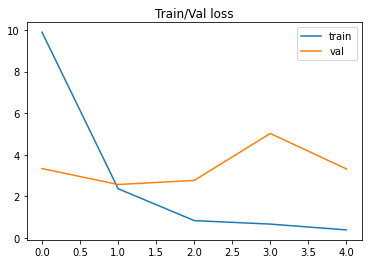

In [ ]:
# training curves

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Train/Val loss')
plt.show()

In [ ]:
print('Training Accuracy', max(val_acc1))

Training Accuracy 99.38888888888889


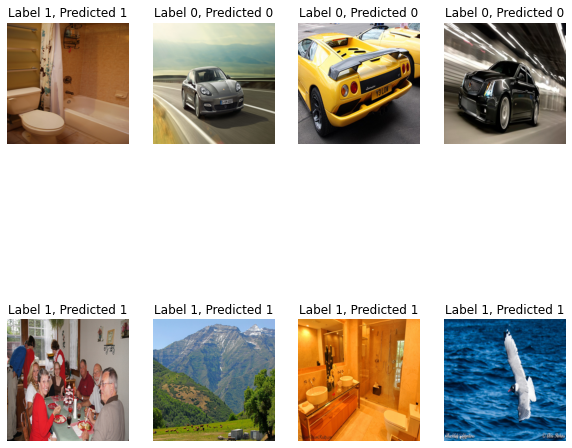

In [ ]:
# show results

r,c = 2,4
f, axs = plt.subplots(r,c, figsize=(10,10))
a= 0

for i in range(r):
  for j in range(c):
    img = Image.open(x_test[a])
    img_transform = transform(img)
    output = model(img_transform.view(1, 3, 224, 224).cuda(0))
    img = img.resize((224, 224))
    axs[i,j].imshow(img)
    axs[i,j].axis('off')
    axs[i,j].set_title(f"Label {int(y_test[a])}, Predicted {np.argmax(output.detach().cpu().numpy()[0])}")
    a+=1

In [ ]:
# # save/load model

#PATH = '/content/resnet_carclassifer.bin'

## save last checkpoint
# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict()
#             }, PATH)

# # load best model weights

# loaded_model = make_model()
# checkpoint = torch.load(PATH)
# loaded_model.load_state_dict(checkpoint['model_state_dict'])
# loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# print('Loaded')


# # fine tune last layer

# LR = 0.001
# EPOCHS = 10

# model.requires_grad_(False) # also for one upper layer
# model.fc.requires_grad_(True)

# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# # scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7)
# scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

# val_loss, train_loss, val_acc2 = train_model(model, EPOCHS, optimizer, scheduler2, 
#                                             512, train_loader, val_loader)

# epochs = np.arange(0,EPOCHS)
# plt.plot(epochs,train_loss)
# plt.plot(epochs,val_loss)
# plt.title('Train/Val loss')
# plt.show()

# print('Fine Tune Accuracy', max(val_acc2))

In [ ]:
#backup model to drive

!cp '/content/resnet_carclassifer.bin' '/content/drive/MyDrive/train/'
print('Model backup complete')

Model backup complete


## Done

Now that the model is ready, we can use it inside an Object detector.